In [1]:
import jax.numpy as jnp  # JAX NumPy
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

2025-12-06 09:50:05.117771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765043405.198287    6086 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765043405.217856    6086 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765043405.347346    6086 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765043405.347369    6086 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765043405.347372    6086 computation_placer.cc:177] computation placer alr

This is next: https://flax.readthedocs.io/en/latest/mnist_tutorial.html

After that, we should get familiar with pytrees, pygraphs, and/or go through examples: https://flax.readthedocs.io/en/latest/examples/index.html

https://flax.readthedocs.io/en/latest/examples/index.html

Let's start with the first tutorial

In [2]:
tf.random.set_seed(0)  # Set the random seed for reproducibility.

train_steps = 1200
eval_every = 200
batch_size = 32

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize train set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # Normalize the test set.

# Create a shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from.
train_ds = train_ds.repeat().shuffle(1024)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

2025-12-06 09:50:08.515295: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Now that we have the data set, let's look into the example model architecture itself.

The way to understand the model's architecture is to look at the `__call__` function

In [3]:
from flax import nnx  # The Flax NNX API.
from functools import partial
from typing import Optional

class CNN(nnx.Module):
    '''A simple CNN model -- see reference document for all documentation '''

    def __init__(self, *, rngs: nnx.Rngs):
        # first block of CNN -- ordering it like how it is called
        # called as:     x = self.avg_pool(nnx.relu(self.batch_norm1(self.dropout1(self.conv1(x), rngs=rngs))))
        self.conv1 = nnx.Conv(in_features=1, 
                              out_features=32, 
                              kernel_size=(3, 3), 
                              rngs=rngs)
        
        self.dropout1 = nnx.Dropout(rate=0.025)

        
        self.batch_norm1 = nnx.BatchNorm(num_features=32, 
                                         rngs=rngs)
        
        ### next is the ReLU (not in class construction)
        
        # now we avg pool
        # partial is here so that we don't have to recall nnx.avg_pool 
        # everytime it needs to be used, bc apparently that's how it works
        self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))

        # now onto the second convolutional block of the CNN
        self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), rngs=rngs)
        self.batch_norm2 = nnx.BatchNorm(64, rngs=rngs)
        self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
        self.linear1 = nnx.Linear(3136, 256, rngs=rngs) # 7 * 7 * 64
        self.dropout2 = nnx.Dropout(rate=0.025)
        self.linear2 = nnx.Linear(256, 10, rngs=rngs)

    def __call__(self, x, rngs: Optional[nnx.Rngs] = None):
        ''' Breaking down the __call__ so I see how each one is carried out '''
        ## first "block" of the CNN
        #x = self.avg_pool(nnx.relu(self.batch_norm1(self.dropout1(self.conv1(x), rngs=rngs))))
        x = self.conv1(x)
        x = self.dropout1(x, rngs=rngs)
        x = self.batch_norm1(x)
        x = nnx.relu(x)
        x = self.avg_pool(x)
        
        ## second "block" of the CNN
        #x = self.avg_pool(nnx.relu(self.batch_norm2(self.conv2(x))))
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = nnx.relu(x)
        x = self.avg_pool(x)
        
        ## now we flatten, and compress it to our linear layers
        x = x.reshape(x.shape[0], -1)
        #x = nnx.relu(self.dropout2(self.linear1(x), rngs=rngs))
        x = self.linear1(x)
        x = self.dropout2(x, rngs=rngs)
        x = nnx.relu(x)
        x = self.linear2(x)
        return x

# Instantiate the model.
model = CNN(rngs=nnx.Rngs(0))
# Visualize it.
nnx.display(model)

### As a simple test, pass random data through the model and see what comes out!

In [4]:
y = model(jnp.ones((1, 28, 28, 1)), nnx.Rngs(0))
y

Array([[ 0.11407785,  0.45457265, -0.64210826, -0.12120566, -0.22857712,
         0.13615231,  1.0126793 , -0.03624355,  0.6132504 , -0.06019139]],      dtype=float32)

### Now let's define the optimizer, simple enough

In [16]:
import optax

learning_rate = 0.005
momentum = 0.9

# how do I actually update the model, well the optimizer has the model within it
# so it makes sense why i woudn't need to pass the model in again
optimizer = nnx.Optimizer(
  model, optax.adamw(learning_rate, momentum), wrt=nnx.Param
)

# I do want to look into how the multi-metric is defined, just looks like object
# wich has accuracy and loss built into it
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

In [6]:
print(optimizer)

Optimizer( # Param: 824,650 (3.3 MB), BatchStat: 192 (768 B), OptArray: 1 (4 B), OptVariable: 1,649,300 (6.6 MB), OptState: 1 (4 B), Total: 2,474,144 (9.9 MB)
  step=OptState( # 1 (4 B)
    value=Array(0, dtype=uint32)
  ),
  model=CNN( # Param: 824,650 (3.3 MB), BatchStat: 192 (768 B), Total: 824,842 (3.3 MB)
    conv1=Conv( # Param: 320 (1.3 KB)
      kernel_shape=(3, 3, 1, 32),
      kernel=Param( # 288 (1.2 KB)
        value=Array(shape=(3, 3, 1, 32), dtype=dtype('float32'))
      ),
      bias=Param( # 32 (128 B)
        value=Array(shape=(32,), dtype=dtype('float32'))
      ),
      in_features=1,
      out_features=32,
      kernel_size=(3, 3),
      strides=1,
      padding='SAME',
      input_dilation=1,
      kernel_dilation=1,
      feature_group_count=1,
      use_bias=True,
      mask=None,
      dtype=None,
      param_dtype=float32,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x72c004c4bbe0>,
      bias_init=<function zeros at 0x72

### Define loss functions and training steps

In [17]:
def loss_fn(model: CNN, rngs: nnx.Rngs, batch):
    # i do want to know the structure of batch here
    logits = model(batch['image'], rngs)
    loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
    ).mean()
    return loss, logits

@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, rngs: nnx.Rngs, batch):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, rngs, batch)
    metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
    optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, rngs: nnx.Rngs, batch):
    loss, logits = loss_fn(model, rngs, batch)
    metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.

### Now we'll train and evaluate the model

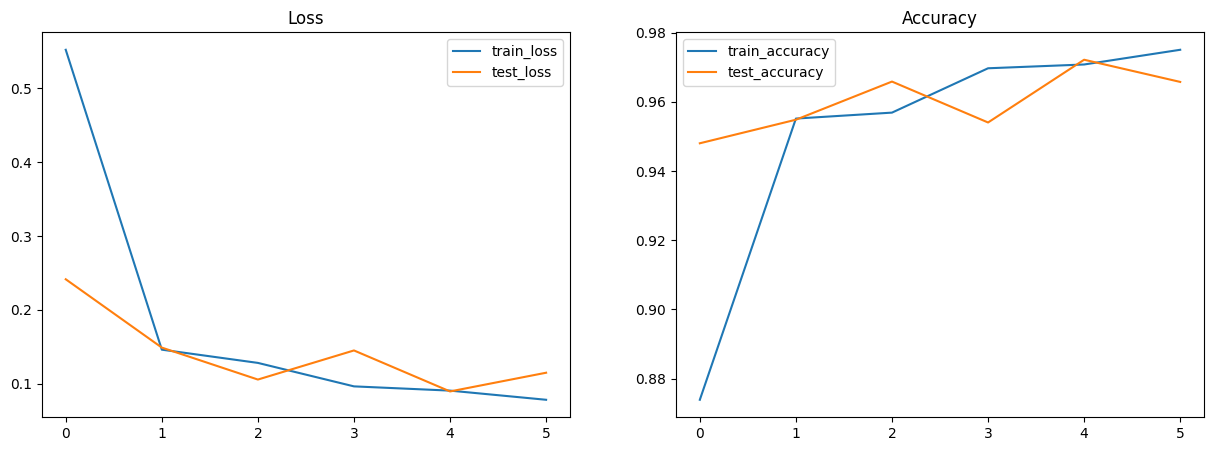

In [18]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

rngs = nnx.Rngs(0)

for step, batch in enumerate(train_ds.as_numpy_iterator()):
    # Run the optimization for one step and make a stateful update to the following:
    # - The train state's model parameters
    # - The optimizer state
    # - The training loss and accuracy batch metrics
    model.train() # Switch to train mode
    train_step(model, optimizer, metrics, rngs, batch)

    if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
        # Log the training metrics.
        for metric, value in metrics.compute().items():  # Compute the metrics.
            metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
        metrics.reset()  # Reset the metrics for the test set.

        # Compute the metrics on the test set after each training epoch.
        model.eval() # Switch to eval mode, like as if it were production
        for test_batch in test_ds.as_numpy_iterator():
            eval_step(model, metrics, rngs, test_batch)

        # Log the test metrics.
        for metric, value in metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)
        metrics.reset()  # Reset the metrics for the next training epoch.

        clear_output(wait=True)
        # Plot loss and accuracy in subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        for dataset in ('train', 'test'):
            ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
            ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
        
        ax1.legend()
        ax2.legend()
        plt.show()

### Now that we've trained the model a bit, we can do some inference

In [20]:
# this disables Dropout and BatchNorm will store the run's statistics
model.eval() # Switch to evaluation mode.

@nnx.jit
def pred_step(model: CNN, batch):
    logits = model(batch['image'])
    return logits.argmax(axis=1)

### And then evaluate the model on the test batch

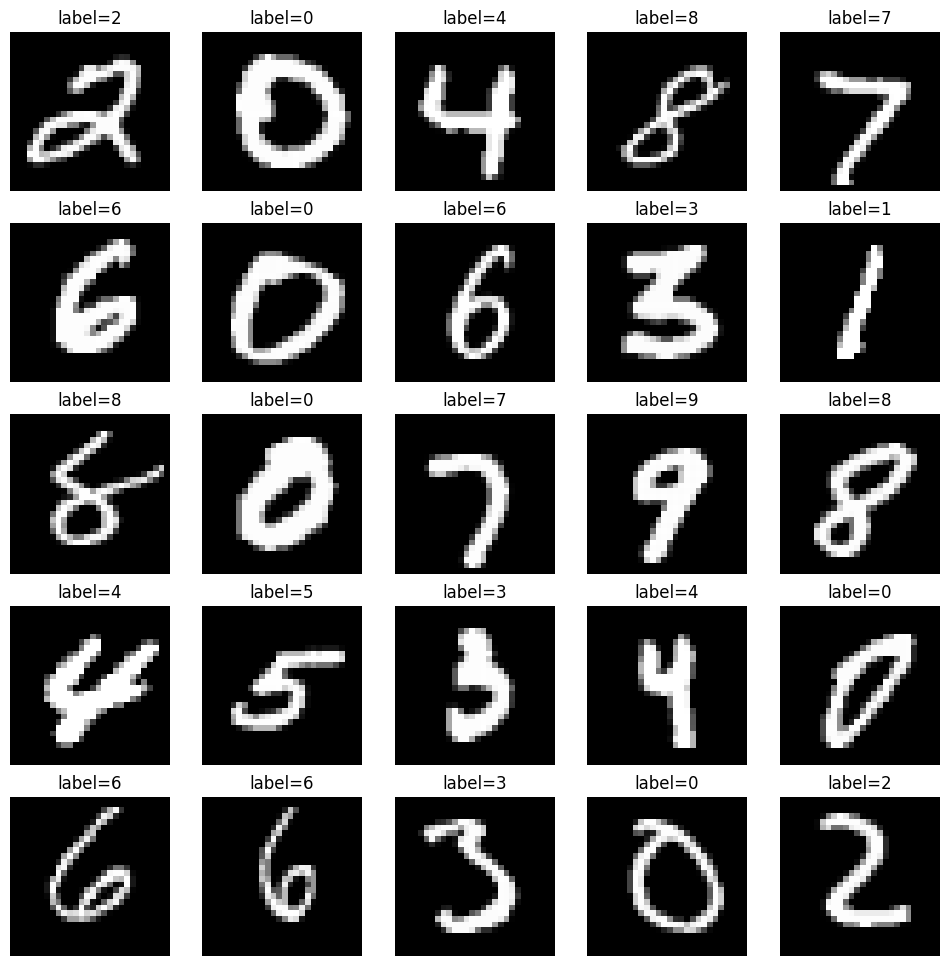

In [21]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f'label={pred[i]}')
    ax.axis('off')